import necessary packet

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import serial
import csv
import matplotlib as mpl
from scipy.signal import butter, filtfilt, freqz
import pandas as pd
from pydwf import (
    DwfLibrary,
    DwfEnumConfigInfo,
    DwfAnalogOutNode,
    DwfAnalogOutFunction,
    DwfAcquisitionMode,
    DwfTriggerSource,
    DwfAnalogInTriggerType,
    DwfTriggerSlope,
    DwfState,
    DwfAnalogInFilter,
    AnalogIn,
    AnalogOut
)
from pydwf.utilities import openDwfDevice




Code block below is my attempted to control the analog discovery, no luck

In [2]:

def control_analog_discovery_oscilloscope(channel=1, sample_rate=1e3, duration=1):
    # Create a DWF library object
    dwf = DwfLibrary()

    # Open the first available device with the best analog input buffer size
    with openDwfDevice(
        dwf,
        score_func=lambda conf_params: conf_params[DwfEnumConfigInfo.AnalogInBufferSize]
    ) as device:
        # Set up the oscilloscope
        analog_in = device.analogIn
        analog_in.channelEnableSet(channel - 1, True)  # Enable the specified channel
        analog_in.channelRangeSet(channel - 1, 5.0)    # Set voltage range to 5V

        analog_in.acquisitionModeSet(DwfAcquisitionMode.Record)  # Set acquisition mode to record
        analog_in.frequencySet(sample_rate)  # Set sample rate
        analog_in.recordLengthSet(duration)  # Set acquisition duration

        # Set trigger parameters
        analog_in.triggerSourceSet(DwfTriggerSource.DetectorAnalogIn)  # Set trigger source to analog input
        analog_in.triggerChannelSet(channel - 1)  # Set trigger channel
        analog_in.triggerLevelSet(0.5)  # Set trigger level to 0.5V
        analog_in.triggerTypeSet(DwfAnalogInTriggerType.Edge)  # Set trigger type to edge

        # Start acquisition
        analog_in.configure(False, True)

        # Wait for acquisition to complete
        time.sleep(duration + 0.5)  # Add a small buffer to ensure acquisition completes

        # Retrieve data
        max_buffer_size = analog_in.bufferSizeInfo() 
        data_count = min(int(sample_rate * duration), max_buffer_size)
        data = analog_in.statusData(channel - 1, data_count)

    return data

# Example usage
if __name__ == "__main__":
    data = control_analog_discovery_oscilloscope(channel=1, sample_rate=1000, duration=1)
    print(data)

DwfLibraryError: DWF Library Error 'UnknownError' (1): 'JTAG init failed, device may be used by another application.\nDjtgEnable failed.\nDevice programming failed.\nDevice:AD2 rev:403 cfg:2 WF:3.21.3\nFDwfDeviceOpenEx'

In [3]:
#load data in two column
def load_data(filename):
    list= []
    with open(filename) as numbers:
        data = csv.reader(numbers, delimiter= ',')
        next(data) #skip_header
        for i in data:
            list.append(i)
    x  = [float(row[0]) for row in list]
    y = [float(row[1]) for row in list]
    return x, y

In [4]:
%matplotlib inline
#select environment for plotting

An example of EEG data processing. We first feed our signal in to gaussian noise, then attemptto filter out the signal we fed in. 

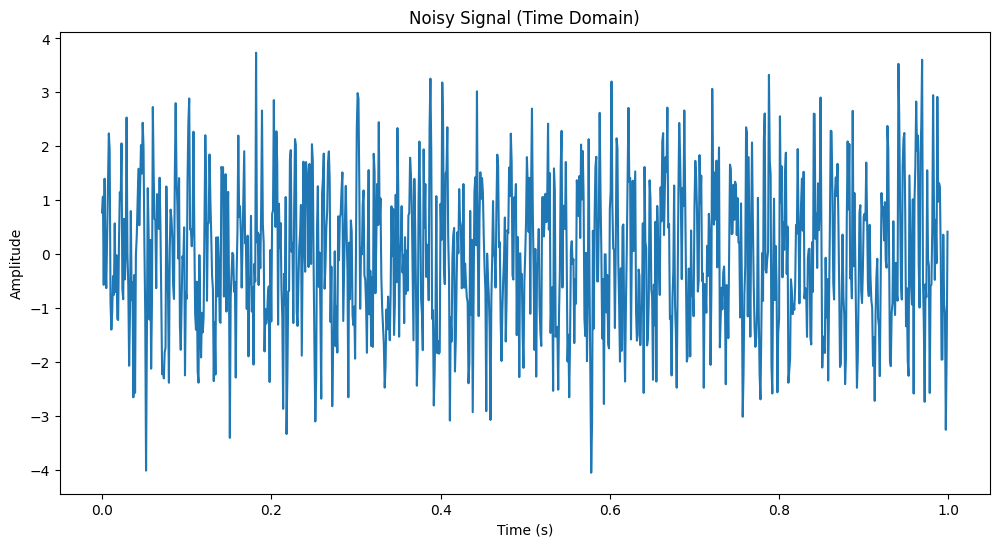

In [3]:


# Parameters
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
f1 = 50  # Frequency of the first sine wave (Hz),
f2 = 150  # Frequency of the second sine wave (Hz)
noise_level = 1  # Noise level

# Create the signal, this is an example of an EEG signal that we wish to extract
signal = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t)
signal1= np.sin(2 * np.pi * f1 * t)  #50 
signal2 =np.sin(2 * np.pi * f2 * t)  #150
noise = noise_level * np.random.randn(len(t))  # Gaussian noise
noisy_signal = signal + noise

# Plot the noisy signal
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal)
plt.title("Noisy Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


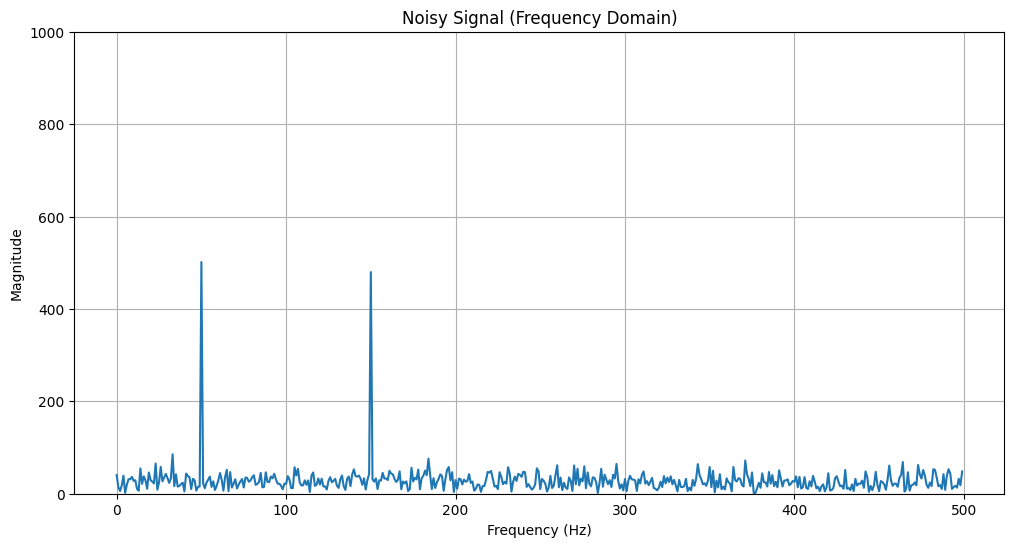

(array([-4.04727702e+01+0.00000000e+00j,  1.34891569e+01+4.02213634e+00j,
        -2.71938627e+00-5.18986718e+00j,  1.78305048e+01+4.98790799e-01j,
         3.55687446e+01+1.63629039e+01j, -1.40297869e+00-1.00360523e+00j,
         1.74316417e+01-8.71096719e+00j, -1.98261226e-02+3.14743322e+01j,
         5.95612885e+00+3.07957423e+01j, -3.42832612e+01+1.21776103e+01j,
        -1.10427007e+01+2.56286716e+01j, -2.87044763e+01-5.37578851e+00j,
        -1.06857463e+01-1.19994750e+00j,  4.84025290e+00+4.38483918e+00j,
        -3.52145023e+01-4.19483369e+01j, -2.13231497e+01-1.66977421e+00j,
         1.60604369e+01+3.39025562e+01j, -8.28223614e+00-2.74405789e+01j,
         7.95719225e+00-7.26669100e+00j,  1.49350692e+01+4.34298171e+01j,
         2.73370065e+01-1.12736091e+01j,  2.30692595e+01+1.25665502e+01j,
        -2.20255906e+01+3.81027891e+00j, -2.48005686e+00-6.53763187e+01j,
        -7.59242111e+00-4.49493913e+00j,  1.92739276e+01-1.50524614e+01j,
        -5.31737081e+01-2.35366044e+01

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def fftfunc_graph(signal, fs, y_limit=20):
    """
    Computes the FFT of a signal and plots the frequency domain representation.

    Parameters:
    - signal (array-like): The input signal.
    - fs (float): The sampling frequency of the signal.
    - y_limit (float): The limit for the Y-axis of the plot.

    Returns:
    - fft_result (numpy array): The FFT of the signal.
    - fft_freqs (numpy array): The corresponding frequencies of the FFT.
    """
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), 1/fs)

    # Plot the FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freqs[:len(fft_freqs)//2], np.abs(fft_result)[:len(fft_freqs)//2])
    plt.ylim(0, y_limit)
    plt.title("Noisy Signal (Frequency Domain)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()
    
    return fft_result, fft_freqs


    
def bandpass_filter(signal, fs, lowcut, highcut):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(fs, b, a, signal)
    return filtered_signal

fftfunc_graph(noisy_signal, fs, y_limit=1000)

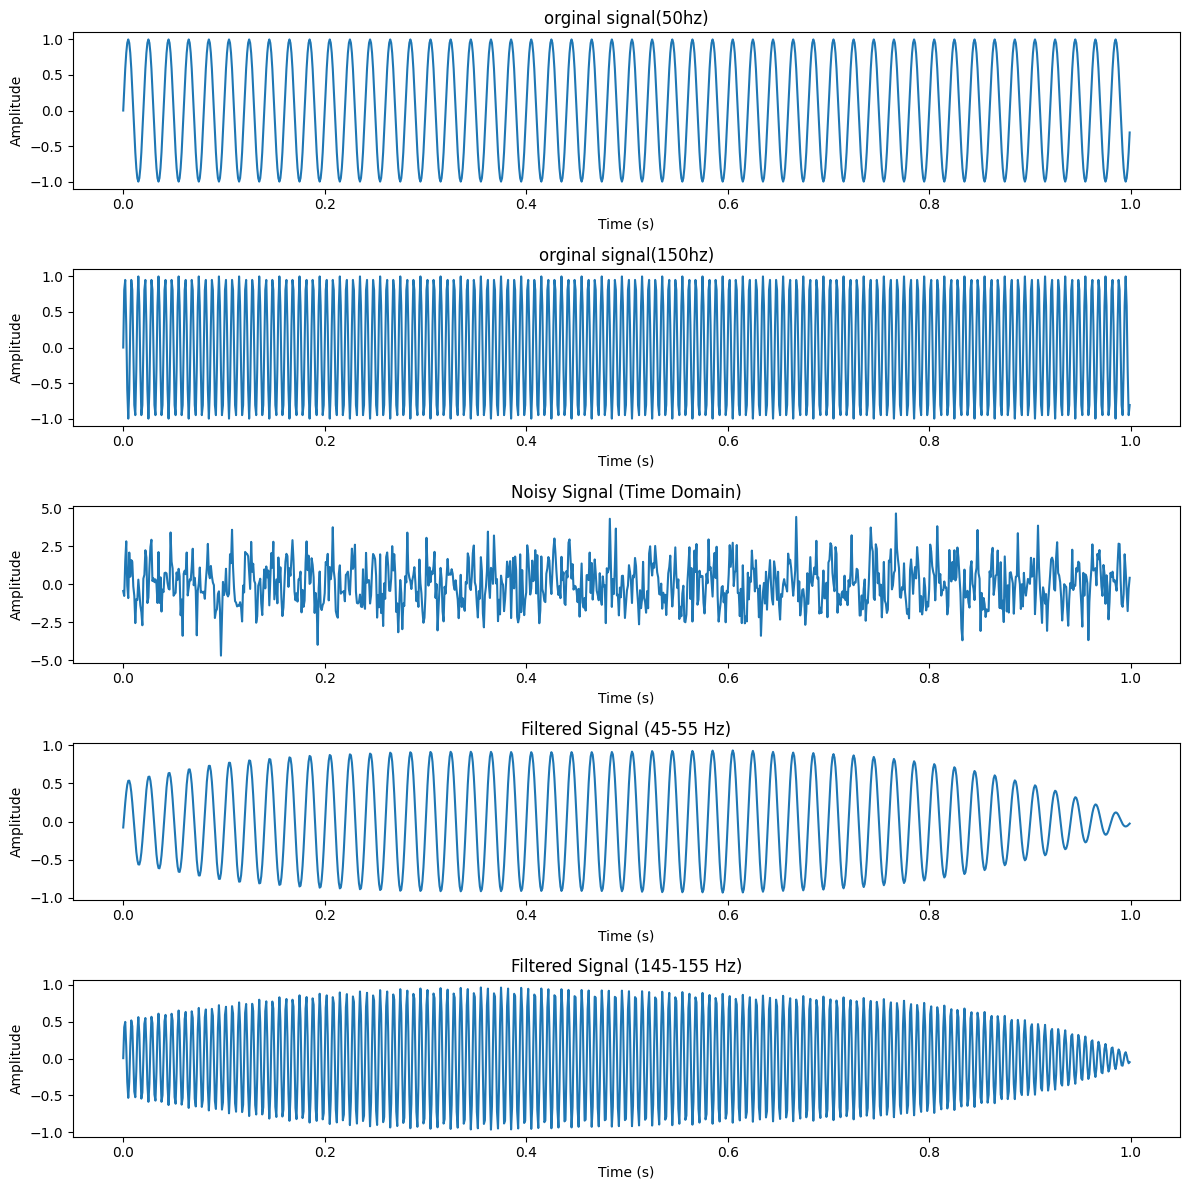

In [7]:


# Apply the filters
filtered_signal_50hz = bandpass_filter(noisy_signal, fs, 49, 51)
filtered_signal_150hz = bandpass_filter(noisy_signal, fs, 149, 151)

# Plot the filtered signals
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(t, signal1)
plt.title("orginal signal(50hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


plt.subplot(5, 1, 2)
plt.plot(t, signal2)
plt.title("orginal signal(150hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


plt.subplot(5, 1, 3)
plt.plot(t, noisy_signal)
plt.title("Noisy Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(5, 1, 4)
plt.plot(t, filtered_signal_50hz)
plt.title("Filtered Signal (45-55 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(5, 1, 5)
plt.plot(t, filtered_signal_150hz)
plt.title("Filtered Signal (145-155 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


This codes below are for controlling the teensy 

In [8]:


def control_teensy(port, baud_rate, sample_rate, running_time, analog_pin):
    """
    Control Teensy 4.1 via serial commands and read analog input from the specified analog pin.

    Parameters:
    - port (str): The serial port (e.g., 'COM3' or '/dev/tty.usbmodem155143201').
    - baud_rate (int): The baud rate for serial communication (e.g., 9600, 115200).
    - sample_rate (int): The total sample rate to be set.
    - running_time (int): The running time in seconds.
    - analog_pin (int): The analog pin to read from (e.g., 14 for A0).
    
    Returns:
    - x_data (list): List of time values in seconds.
    - y_data (list): List of corresponding voltage readings.
    """
    try:
        # Open serial connection
        with serial.Serial(port, baud_rate, timeout=1) as ser:
            # Give some time to establish the connection
            time.sleep(2)

            # Construct command string
            command = f"SET SR {sample_rate};RT {running_time};AP {analog_pin}\n"

            # Send command to Teensy
            ser.write(command.encode())
            print(f"Command sent: {command.strip()}")

            # Read and store responses from Teensy
            start_time = time.time()
            x_data = []
            y_data = []
            while time.time() - start_time < running_time:
                if ser.in_waiting > 0:
                    response = ser.readline().decode().strip()
                    if "Voltage" in response:
                        print("Response from Teensy:", response)
                        try:
                            # Extract the voltage value from the response
                            voltage = float(response.split(", Voltage: ")[1])
                            timestamp = time.time() - start_time
                            x_data.append(timestamp)
                            y_data.append(voltage)
                        except (IndexError, ValueError):
                            continue

            end_time = time.time()

            # Calculate total run time and total samples
            total_run_time = end_time - start_time
            total_samples = len(y_data)

            # Print total run time and total samples
            print(f"Total run time: {total_run_time:.2f} seconds")
            print(f"Total samples: {total_samples}")
            #print(f"Sampling rate: {tota}")

            # Plot the data
            plt.figure(figsize=(10, 5))
            plt.plot(x_data, y_data)  # No marker argument to only draw lines between data points
            plt.title("Voltage Readings from Teensy 4.1")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.grid(True)
            plt.show()

            return x_data, y_data

    except serial.SerialException as e:
        print(f"Error communicating with Teensy: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return [], []

# Example usage:


Command sent: SET SR 200;RT 5;AP 14
Response from Teensy: Analog Read: 334, Voltage: 3.26
Response from Teensy: Analog Read: 341, Voltage: 3.33
Response from Teensy: Analog Read: 346, Voltage: 3.38
Response from Teensy: Analog Read: 342, Voltage: 3.34
Response from Teensy: Analog Read: 347, Voltage: 3.39
Response from Teensy: Analog Read: 349, Voltage: 3.41
Response from Teensy: Analog Read: 342, Voltage: 3.34
Response from Teensy: Analog Read: 338, Voltage: 3.30
Response from Teensy: Analog Read: 340, Voltage: 3.32
Response from Teensy: Analog Read: 338, Voltage: 3.30
Response from Teensy: Analog Read: 339, Voltage: 3.31
Response from Teensy: Analog Read: 346, Voltage: 3.38
Response from Teensy: Analog Read: 342, Voltage: 3.34
Response from Teensy: Analog Read: 337, Voltage: 3.29
Response from Teensy: Analog Read: 340, Voltage: 3.32
Response from Teensy: Analog Read: 342, Voltage: 3.34
Response from Teensy: Analog Read: 334, Voltage: 3.26
Response from Teensy: Analog Read: 338, Voltag

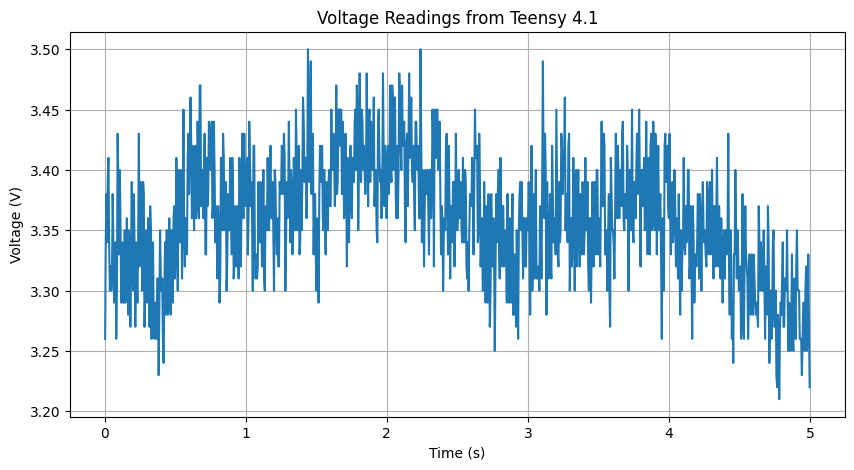

In [13]:
# Example usage:
x, y = control_teensy('/dev/tty.usbmodem155143201', 115200, 200, 5, 14)  # 14 corresponds to A0 on Teensy, to find the port do "ls /dev/tty.*" in terminal

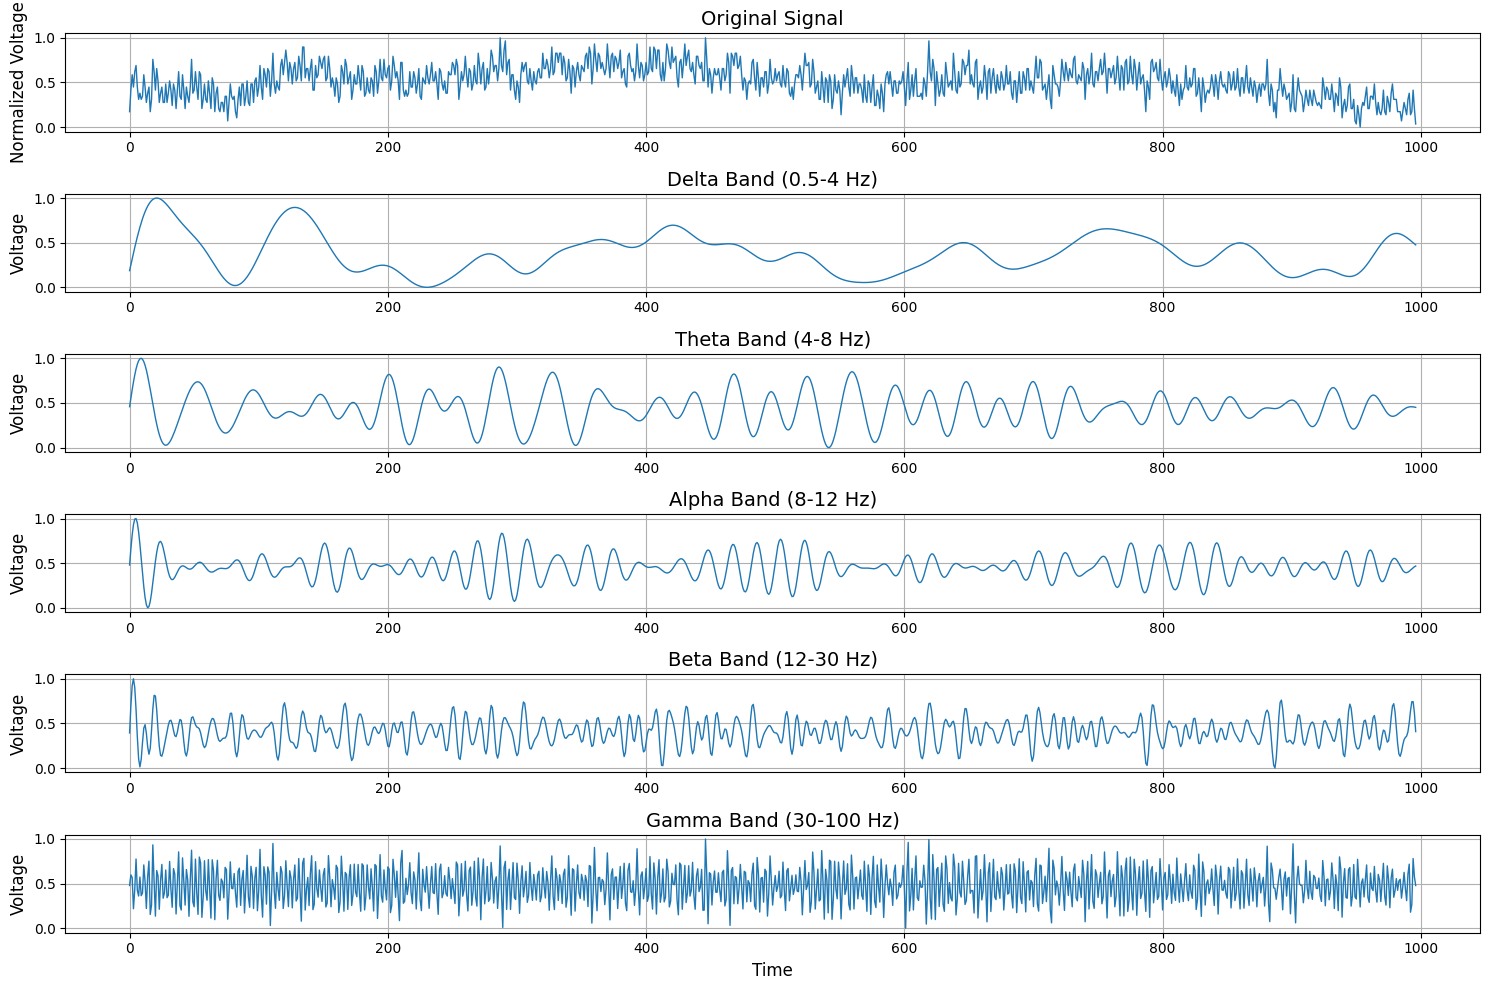

In [64]:


# Load the CSV file and extract columns into two lists
time, signal = pd.read_csv('teensy_data.csv', header=0).values.T.tolist()

def bandpass_filter(signal, order, lowcut, highcut, fs):
    """
    Apply a bandpass Butterworth filter to a signal.
    
    Parameters:
    - signal (array-like): The input signal.
    - order (int): The order of the Butterworth filter.
    - lowcut (float): The low cutoff frequency for the bandpass filter.
    - highcut (float): The high cutoff frequency for the bandpass filter.
    - fs (float): The sampling frequency of the signal.

    Returns:
    - filtered_signal (array-like): The filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def normalize_signal(signal):
    """
    Normalize the signal to the range [0, 1].
    
    Parameters:
    - signal (array-like): The input signal to be normalized.

    Returns:
    - normalized_signal (array-like): The normalized signal.
    """
    scaler = MinMaxScaler()
    signal = np.array(signal).reshape(-1, 1)
    normalized_signal = scaler.fit_transform(signal).flatten()
    return normalized_signal

def filter_noise(signal, order, fs, plot=True):
    """
    Filters noise from the signal using bandpass Butterworth filters for different frequency bands.
    
    Parameters:
    - signal (array-like): The raw signal data to be filtered.
    - order (int): The order of the Butterworth filter.
    - fs (float): The sampling frequency of the signal.
    - plot (bool): Whether to plot the original and filtered signals.

    Returns:
    - (tuple): Filtered signals for delta, theta, alpha, and gamma bands.
    """
    # Apply bandpass filters for different brainwave bands
    deltawave = bandpass_filter(signal, order, lowcut=0.5, highcut=4, fs=fs)
    thetawave = bandpass_filter(signal, order, lowcut=4, highcut=8, fs=fs)
    alphawave = bandpass_filter(signal, order, lowcut=8, highcut=12, fs=fs)
    betawave = bandpass_filter(signal, order, lowcut=12, highcut=30, fs=fs)
    gammawave = bandpass_filter(signal, order, lowcut=30, highcut=80, fs=fs)

    
    # Normalize the signals
    signal = normalize_signal(signal)
    deltawave = normalize_signal(deltawave)
    thetawave = normalize_signal(thetawave)
    alphawave = normalize_signal(alphawave)
    betawave = normalize_signal(betawave)
    gammawave = normalize_signal(gammawave)
    
    # Plot the original and filtered signals
    if plot:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(6, 1, 1)
        plt.plot(signal, linewidth=1, label='Original')
        plt.ylabel('Normalized Voltage', fontsize=12)
        plt.title("Original Signal", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 2)
        plt.plot(deltawave, linewidth=1, label='Delta (0.5-4 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Delta Band (0.5-4 Hz)", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 3)
        plt.plot(thetawave, linewidth=1, label='Theta (4-8 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Theta Band (4-8 Hz)", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 4)
        plt.plot(alphawave, linewidth=1, label='Alpha (8-12 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Alpha Band (8-12 Hz)", fontsize=14)
        plt.grid(True)
        
        plt.subplot(6, 1, 5)
        plt.plot(betawave, linewidth=1, label='beta (12-30 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.title("Beta Band (12-30 Hz)", fontsize=14)
        plt.grid(True)

        plt.subplot(6, 1, 6)
        plt.plot(gammawave, linewidth=1, label='Gamma (30-100 Hz)')
        plt.ylabel('Voltage', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.title("Gamma Band (30-100 Hz)", fontsize=14)
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return deltawave, thetawave, alphawave,betawave, gammawave

# Filter and plot the signal
deltawave, thetawave, alphawave,betawave ,gammawave = filter_noise(signal, order=5, fs=199)

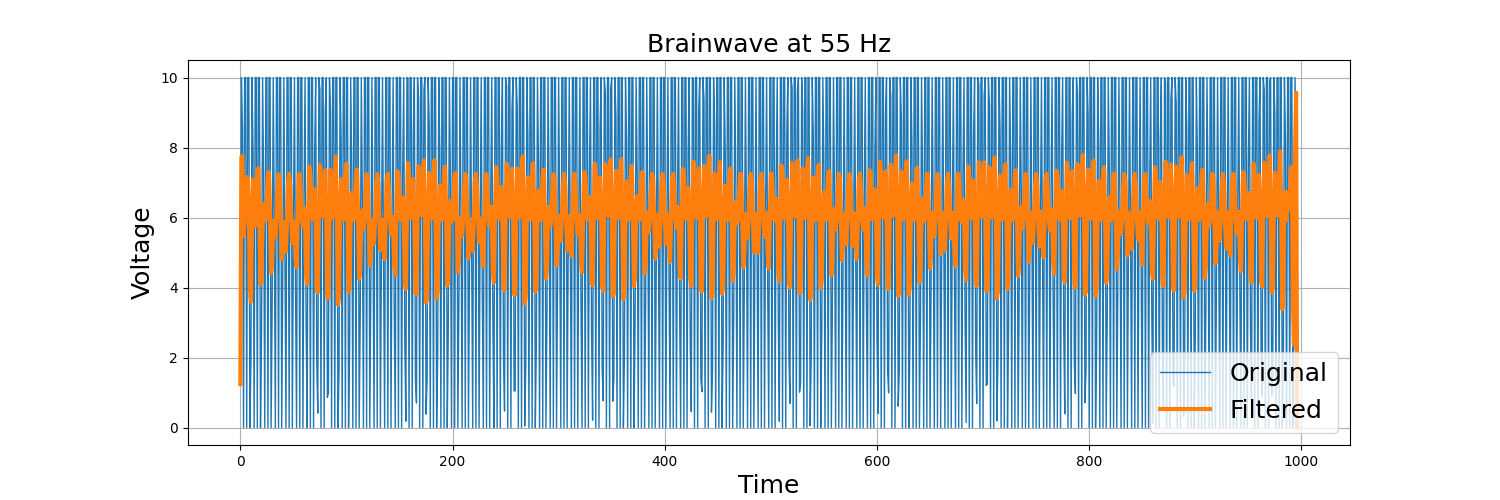

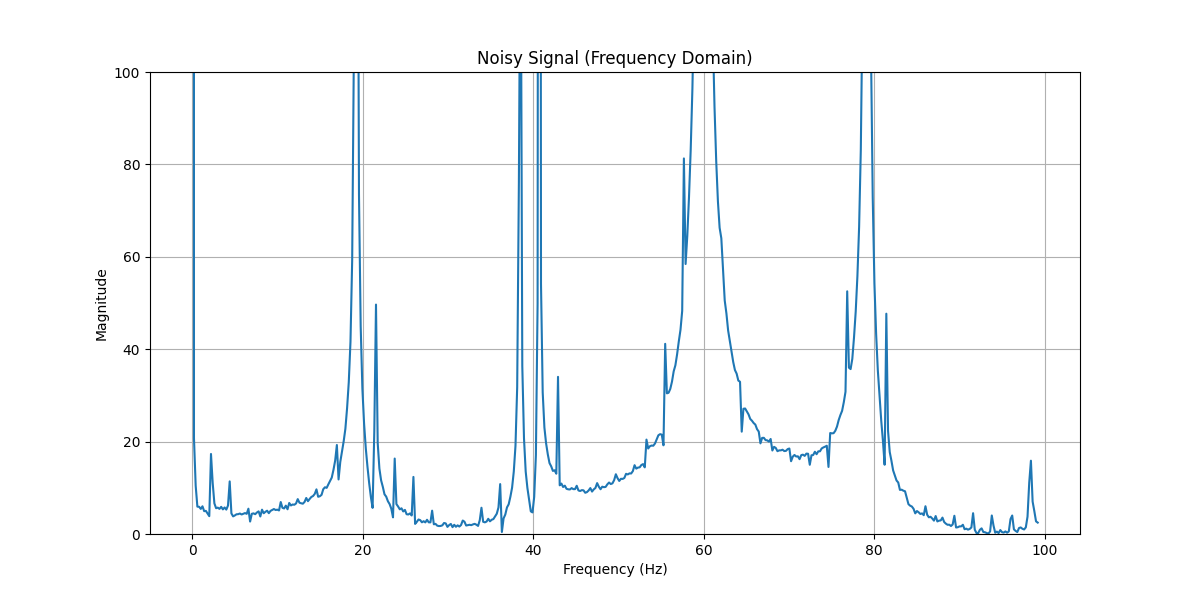

(array([ 6.02629000e+03+1.06581410e-13j, -1.16997656e+01+1.70962588e+01j,
        -4.89335124e+00+9.24686757e+00j, -4.25616029e+00+4.11685033e+00j,
        -4.68704786e+00+3.58158060e+00j, -4.12557443e+00+3.53585183e+00j,
        -4.14833775e+00+4.33266355e+00j, -4.10056287e+00+2.76390202e+00j,
        -4.22202815e+00+2.68157101e+00j, -3.10690901e+00+3.15797174e+00j,
        -2.01547984e+00+3.29119186e+00j, -3.75078334e+00+1.69128083e+01j,
        -8.84119057e+00-6.61641327e+00j, -6.33538981e+00-1.94478728e+00j,
        -5.44691309e+00-1.22596630e+00j, -5.66638545e+00-6.74752159e-01j,
        -5.40976463e+00-5.55610881e-01j, -5.83860681e+00-7.10128762e-01j,
        -5.18173396e+00-1.22180282e+00j, -5.69025605e+00-8.04044383e-01j,
        -5.25562474e+00-5.18129053e-01j, -5.99414210e+00-1.43506878e+00j,
        -1.11740932e+01-2.19382404e+00j,  1.15655174e+00-4.31139793e+00j,
        -3.35882915e+00-1.80787808e+00j, -3.74858829e+00-1.43476603e+00j,
        -3.84984804e+00-1.83716432e+00

In [72]:
filter_noise(y2)
fftfunc_graph(y2, fs, y_limit=100)

In [65]:

def write_to_csv(x_data, y_data, filename="output_data.csv"):
    """
    Writes x and y data to a CSV file.

    Parameters:
    - x_data (list): List of x values (e.g., time values in seconds).
    - y_data (list): List of y values (e.g., voltage readings).
    - filename (str): The name of the CSV file to write the data to.
    """
    # Ensure x_data and y_data are of the same length
    if len(x_data) != len(y_data):
        raise ValueError("x_data and y_data must have the same length.")
    
    # Write the data to a CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Time (s)", "Voltage (V)"])
        for x, y in zip(x_data, y_data):
            writer.writerow([x, y])


In [66]:
write_to_csv(x, y, filename="teensy_data.csv") 